# Stock Market Prediction using RNN (LSTM/GRU) with yfinance data

Epoch 1/60
69/69 - 10s - 151ms/step - loss: 1.5961 - mse: 1.5961 - val_loss: 1.0331 - val_mse: 1.0331
Epoch 2/60
69/69 - 4s - 62ms/step - loss: 1.5825 - mse: 1.5825 - val_loss: 1.0324 - val_mse: 1.0324
Epoch 3/60
69/69 - 4s - 63ms/step - loss: 1.5717 - mse: 1.5717 - val_loss: 1.0315 - val_mse: 1.0315
Epoch 4/60
69/69 - 5s - 68ms/step - loss: 1.5626 - mse: 1.5626 - val_loss: 1.0318 - val_mse: 1.0318
Epoch 5/60
69/69 - 5s - 66ms/step - loss: 1.5520 - mse: 1.5520 - val_loss: 1.0351 - val_mse: 1.0351
Epoch 6/60
69/69 - 5s - 67ms/step - loss: 1.5415 - mse: 1.5415 - val_loss: 1.0375 - val_mse: 1.0375
Epoch 7/60
69/69 - 5s - 67ms/step - loss: 1.5297 - mse: 1.5297 - val_loss: 1.0461 - val_mse: 1.0461
Epoch 8/60
69/69 - 5s - 67ms/step - loss: 1.5201 - mse: 1.5201 - val_loss: 1.0562 - val_mse: 1.0562
Epoch 9/60
69/69 - 5s - 67ms/step - loss: 1.5008 - mse: 1.5008 - val_loss: 1.0721 - val_mse: 1.0721
Epoch 10/60
69/69 - 5s - 69ms/step - loss: 1.4816 - mse: 1.4816 - val_loss: 1.0997 - val_mse: 1.09

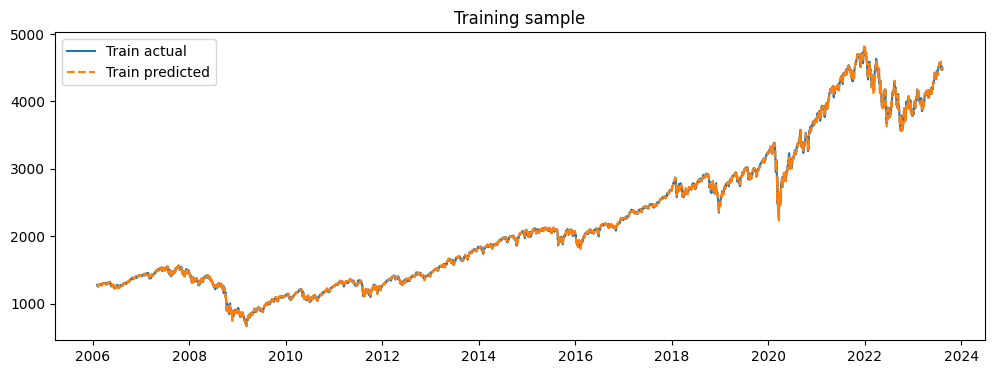

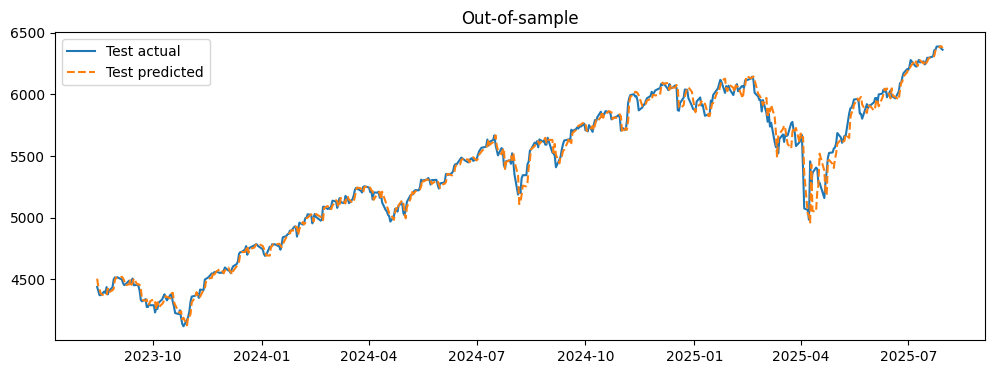

Saved → spx_lstm.keras


In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""
LSTM forecast of S&P-500 next-day close return (TensorFlow 2 + Keras 3)
"""

# ---------- 0) imports ----------
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
tf.random.set_seed(42)

# ---------- 1) data ----------
TICKER, START, WINDOW = "^GSPC", "2006-01-01", 20

raw = (
    yf.Ticker(TICKER)
      .history(start=START, auto_adjust=False)
      .loc[:, ["High", "Low", "Close"]]
      .dropna()
)
rets = (raw.div(raw["Close"].shift(1), axis=0) - 1.0) * 100.0
rets.dropna(inplace=True)

n_total = len(rets) - WINDOW + 1
X = np.zeros((n_total, WINDOW-1, 3), dtype=np.float32)
y = np.zeros((n_total, 1),            dtype=np.float32)
for i in range(n_total):
    X[i] = rets.iloc[i:i+WINDOW-1].values
    y[i] = rets.iloc[i+WINDOW-1, 2]

split = int(n_total * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# ---------- 2) model ----------
N_NEURONS, N_LAYERS = 128, 2
LR, BATCH, EPOCHS   = 1e-3, 64, 60

model = tf.keras.Sequential(name="lstm_regressor")
model.add(tf.keras.layers.Input(shape=(WINDOW-1, 3)))
for i in range(N_LAYERS):
    model.add(tf.keras.layers.LSTM(
        N_NEURONS,
        activation="tanh",
        return_sequences=(i < N_LAYERS-1)
    ))
model.add(tf.keras.layers.Dense(1))

model.compile(optimizer=tf.keras.optimizers.Adam(LR),
              loss="mse", metrics=["mse"])

# (Optional) print a quiet summary without triggering the bug
# model.summary(print_fn=lambda *args, **kwargs: None)

# ---------- 3) train ----------
model.fit(
    X_train, y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    validation_data=(X_test, y_test),
    verbose=2
)

# ---------- 4) predict ----------
pred_tr = model.predict(X_train, batch_size=BATCH).flatten()
pred_te = model.predict(X_test,  batch_size=BATCH).flatten()

# ---------- 5) convert return → price ----------
close      = raw["Close"]
idx_tr     = close.index[WINDOW : WINDOW+split]
idx_te     = close.index[WINDOW+split : WINDOW+n_total]
prev_close = close.shift(1)

price_tr = prev_close.loc[idx_tr] * (1 + pred_tr/100.0)
price_te = prev_close.loc[idx_te] * (1 + pred_te/100.0)

# ---------- 6) plot ----------
plt.figure(figsize=(12,4))
plt.plot(idx_tr, close.loc[idx_tr], label="Train actual")
plt.plot(idx_tr, price_tr, "--", label="Train predicted")
plt.title("Training sample"); plt.legend(); plt.show()

plt.figure(figsize=(12,4))
plt.plot(idx_te, close.loc[idx_te], label="Test actual")
plt.plot(idx_te, price_te, "--", label="Test predicted")
plt.title("Out-of-sample"); plt.legend(); plt.show()

# ---------- 7) save ----------
model.save("spx_lstm.keras")
print("Saved → spx_lstm.keras")
